In [1]:
import dotenv
import os
import sys
from PIL import Image 
from matplotlib import pyplot
from numpy import asarray, resize, prod, array

In [4]:
from loader import Loader

loader = Loader((224, 224))

In [5]:
dataset = loader.create_dataset()
dataset.summary()

-------------------- Dataset Summary --------------------

Number of train images :  5216


Number of test images :  624


Number of validation images :  16


Shape of each images :  (224, 224, 3)
---------------------------------------------------------


# Autoencoder

In [4]:
# Tensorboard init

%load_ext tensorboard
%tensorboard --logdir logs/fit

ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.

In [22]:
def load_image(path) :
    target_size = (256,256)
    try : return resize(asarray(Image.open(path)), target_size)/255.
    except : None

train_img = [load_image(image_dir) for image_dir in images_dir]
test_img = [load_image(image_dir) for image_dir in test_dir]

train_img = [img for img in train_img if img is not None]
test_img = [img for img in test_img if img is not None]

In [23]:
print(train_img[0])
print(len(train_img))
print('----------')
print(test_img[0])
print(len(test_img))

[[0.         0.09019608 0.09411765 ... 0.10980392 0.11372549 0.12156863]
 [0.11372549 0.10980392 0.10980392 ... 0.09803922 0.10588235 0.09803922]
 [0.10196078 0.09803922 0.10196078 ... 0.04705882 0.04705882 0.04705882]
 ...
 [0.62745098 0.65490196 0.61960784 ... 0.60784314 0.60784314 0.62745098]
 [0.63529412 0.61176471 0.62352941 ... 0.30196078 0.30588235 0.35686275]
 [0.32941176 0.30980392 0.30196078 ... 0.07843137 0.06666667 0.06666667]]
1341
----------
[[0.00392157 0.10196078 0.08627451 ... 0.0627451  0.0627451  0.0627451 ]
 [0.05490196 0.05490196 0.0627451  ... 0.2        0.23137255 0.18431373]
 [0.23137255 0.23529412 0.23921569 ... 0.51764706 0.51372549 0.5254902 ]
 ...
 [0.22352941 0.22745098 0.23137255 ... 0.47843137 0.47843137 0.48627451]
 [0.49019608 0.4745098  0.45882353 ... 0.74509804 0.74117647 0.75294118]
 [0.76078431 0.75294118 0.74117647 ... 0.59607843 0.58823529 0.57254902]]
234


In [34]:
import numpy as np

train_img = array(train_img)
test_img = array(test_img)
train_img = np.expand_dims(train_img, axis=-1)
test_img = np.expand_dims(test_img, axis=-1)

In [9]:
import keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Dropout
from keras.models import Model
import tensorflow as tf
import datetime

In [10]:
input_img = Input(shape=(256, 256, 1)) 

x = Conv2D(128, (3, 3), activation='relu', padding='same')(input_img)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Dropout(0.5)(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Dropout(0.5)(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Dropout(0.5)(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Dropout(0.5)(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [11]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 128)     1280      
                                                                 
 batch_normalization (Batch  (None, 256, 256, 128)     512       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 128)     0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 128)     147584    
                                                                 
 dropout (Dropout)           (None, 128, 128, 128)     0     

In [12]:
print(autoencoder.output_shape)

(None, 256, 256, 1)


In [13]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
autoencoder.fit(train_img, train_img,
                epochs=25,
                batch_size=128,
                shuffle=True,
                validation_data=(test_img, test_img), 
                callbacks=[tensorboard_callback])

Epoch 1/25
11/11 [==============================] - 602s 55s/step - loss: 0.7273 - val_loss: 0.6930
Epoch 2/25
11/11 [==============================] - 1459s 141s/step - loss: 0.6694 - val_loss: 0.6928
Epoch 3/25
11/11 [==============================] - 670s 62s/step - loss: 0.6646 - val_loss: 0.6925
Epoch 4/25
11/11 [==============================] - 38861s 3881s/step - loss: 0.6624 - val_loss: 0.6915
Epoch 5/25
11/11 [==============================] - 60823s 6078s/step - loss: 0.6613 - val_loss: 0.6909
Epoch 6/25
11/11 [==============================] - 14928s 815s/step - loss: 0.6601 - val_loss: 0.6904
Epoch 7/25
11/11 [==============================] - 497s 45s/step - loss: 0.6589 - val_loss: 0.6889
Epoch 8/25
11/11 [==============================] - 521s 47s/step - loss: 0.6501 - val_loss: 0.6888
Epoch 9/25
11/11 [==============================] - 522s 47s/step - loss: 0.6304 - val_loss: 0.6872
Epoch 10/25
11/11 [==============================] - 1206s 115s/step - loss: 0.6173 - v

# Test

In [3]:
encoder = Model(input_img, encoded)

encoded_input = Input(shape=((32,32,128)))
x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded_input)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded_output = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

decoder = Model(encoded_input, decoded_output)

NameError: name 'Model' is not defined

1/1 [==============================] - 0s 84ms/step


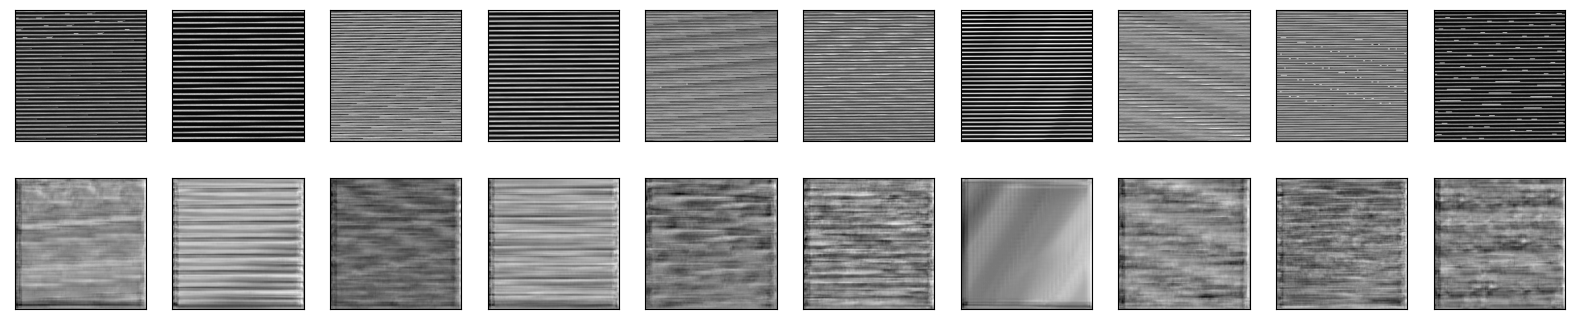

In [15]:
encoded_imgs = encoder.predict(test_img[:10])
decoded_imgs = decoder.predict(encoded_imgs)

import matplotlib.pyplot as plt

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_img[i].reshape(256, 256))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(256, 256))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# VGG16

In [6]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Input, Conv2D, Lambda, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import optimizers
import tensorflow as tf

vgg_conv = VGG16(weights='./vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False, input_shape=(224, 224, 3))

for layer in vgg_conv.layers[:-8]:
    layer.trainable = False

x = vgg_conv.output
x = GlobalAveragePooling2D()(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(vgg_conv.input, x)
model.compile(loss = "binary_crossentropy", optimizer = optimizers.SGD(lr=0.005, momentum=0.9), metrics=["accuracy"])

In [7]:
import datetime

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
model.fit(dataset.train_images, dataset.train_labels,
          epochs=25,
          batch_size=128,
          shuffle=True,
          validation_data=(dataset.val_images, dataset.val_labels),
          callbacks=[tensorboard_callback])

Epoch 1/25
41/41 [==============================] - 1298s 32s/step - loss: 0.5143 - accuracy: 0.7598 - val_loss: 0.6460 - val_accuracy: 0.5625
Epoch 2/25
41/41 [==============================] - 1782s 44s/step - loss: 0.3210 - accuracy: 0.8616 - val_loss: 0.7011 - val_accuracy: 0.5000
Epoch 3/25
41/41 [==============================] - 1205s 29s/step - loss: 0.2833 - accuracy: 0.8758 - val_loss: 0.5182 - val_accuracy: 0.7500
Epoch 4/25
41/41 [==============================] - 23597s 589s/step - loss: 0.2762 - accuracy: 0.8785 - val_loss: 0.7222 - val_accuracy: 0.6875
Epoch 5/25
41/41 [==============================] - 14605s 266s/step - loss: 0.2698 - accuracy: 0.8808 - val_loss: 0.7296 - val_accuracy: 0.6875
Epoch 6/25
41/41 [==============================] - 1336s 33s/step - loss: 0.2495 - accuracy: 0.8946 - val_loss: 0.6313 - val_accuracy: 0.7500
Epoch 7/25
41/41 [==============================] - 1436s 35s/step - loss: 0.2535 - accuracy: 0.8907 - val_loss: 0.5051 - val_accuracy: 0.

In [13]:
model.evaluate(dataset.test_images, dataset.test_labels, verbose=2)

20/20 - 60s - loss: 1.9468 - accuracy: 0.7628 - 60s/epoch - 3s/step


[1.94683039188385, 0.7628205418586731]

In [8]:
model.save_weights('./checkpoints/my_checkpoint')

In [9]:
model.save('saved_model/my_model')

INFO:tensorflow:Assets written to: saved_model/my_model/assets


INFO:tensorflow:Assets written to: saved_model/my_model/assets


In [26]:
import scipy.ndimage as sp
import matplotlib.pyplot as plt
import numpy as np

def plot_activation(img):
    pred = model.predict(img[np.newaxis,:,:,:])
    pred_class = np.argmax(pred)
    weights = model.layers[-1].get_weights()[0]
    class_weights = weights[:, pred_class]
    intermediate = Model(model.input,
                         model.get_layer("block5_conv3").output)
    conv_output = intermediate.predict(img[np.newaxis,:,:,:])
    conv_output = np.squeeze(conv_output)
    h = int(img.shape[0]/conv_output.shape[0])
    w = int(img.shape[1]/conv_output.shape[1])
    act_maps = sp.zoom(conv_output, (h, w, 1), order=1)
    out = np.dot(act_maps.reshape((img.shape[0]*img.shape[1],512)), 
                 class_weights).reshape(img.shape[0],img.shape[1])
    plt.imshow(img.astype('float32').reshape(img.shape[0],
               img.shape[1],3))
    plt.imshow(out, cmap='jet', alpha=0.35)
    plt.title('Crack' if pred_class == 1 else 'No Crack')

1


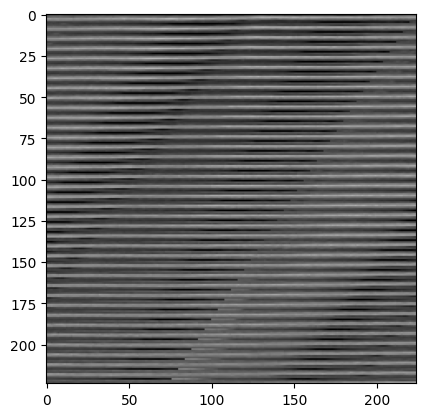

In [41]:
plt.imshow(dataset.test_images[2])
print(dataset.test_labels[500])

1/1 [==============================] - 0s 155ms/step


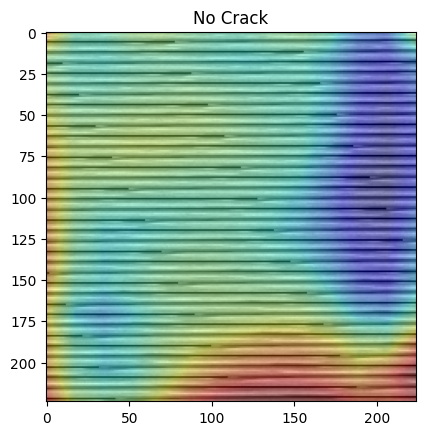

In [27]:
plot_activation(dataset.train_images[1])